In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
import pandas as pd
import numpy as np
import math

# graph related library
import networkx as nx
import leidenalg
import igraph as ig
import community as community_louvain
import networkx.algorithms.community as nx_comm

### DBLP collaboration network and ground-truth communities

The DBLP computer science bibliography provides a comprehensive list of research papers in computer science. We construct a co-authorship network where two authors are connected if they publish at least one paper together. Publication venue, e.g, journal or conference, defines an individual ground-truth community; authors who published to a certain journal or conference form a community.

Dataset download link: https://snap.stanford.edu/data/com-DBLP.html

In [2]:
DBLP = pd.read_csv('com-dblp.ungraph.txt', 
                   sep='\t', header=None, skiprows = 4, 
                   names=['node1', 'node2'])

In [3]:
%%time

# create graph from edge list
DBLP_network = nx.Graph(DBLP.values.tolist())

Wall time: 4.27 s


In [4]:
def get_graph_info(graph):
    print("Number of nodes:", graph.number_of_nodes())
    print("Number of edges:", graph.number_of_edges())
    print("Average Cluster Coefficients:", nx.average_clustering(graph))
    print("Connected components:", len(list(nx.connected_components(graph))))

In [5]:
%%time
get_graph_info(DBLP_network)

Number of nodes: 317080
Number of edges: 1049866
Average Cluster Coefficients: 0.6324308280637396
Connected components: 1
Wall time: 18 s


#### We have 317080 nodes and 1049866 edges. Overall, the probability of adjacent nodes being connected is 63.24%. The graph is connected with no separation because we have 1 connected component.

### 1. Louvain Algorithm for Community Detection

In [12]:
%%time

louvain_communities = community_louvain.best_partition(DBLP_network, random_state=0)

Wall time: 4min 57s


In [88]:
# convert community dictionary to a list of community node lists
# made for Louvain output and Leiden output
def convert_communities_dict_to_list(communities_dict):
    unique_partition_count = len(list(set(communities_dict.values())))
    print("Number of unique communities:", unique_partition_count)
    communities = [[] for i in range(unique_partition_count)]
    for node in communities_dict.keys():
        communities[communities_dict[node]].append(node)
    return communities

In [14]:
louvain_communities = convert_communities_dict_to_list(louvain_communities)

Number of unique communities: 198


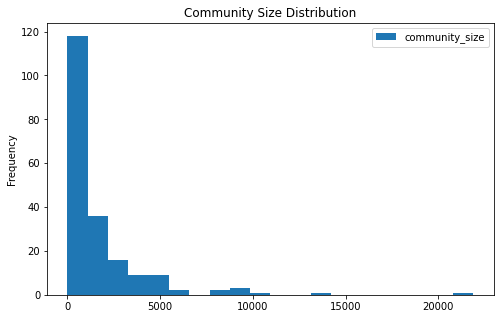

In [19]:
community_sizes = pd.DataFrame([len(community) for community in louvain_communities], 
                               columns=["community_size"])
community_sizes.plot.hist(bins=20, figsize=(8,5), title="Community Size Distribution");

In [27]:
%%time

# take a look at the modularity of the Louvain algorithm output
print("Modularity:", 
      round(nx_comm.modularity(DBLP_network, louvain_communities), 6))

Modularity: 0.821751
Wall time: 3.63 s


In [21]:
# function to check whether the determined communities are connected
def check_community_disconnection(graph, communities):
    total_connected = 0
    disconnected_community_indexes = []
    for i in range(len(communities)):
        if nx.is_connected(graph.subgraph(communities[i])):
            total_connected += 1
        else:
            disconnected_community_indexes.append(i)
    print("Total Communities:", len(communities))
    print("Total Communities Connected:", total_connected)
    print("Disconnected Community Indexes:", disconnected_community_indexes)

In [23]:
%%time

check_community_disconnection(DBLP_network, louvain_communities)

Total Communities: 198
Total Communities Connected: 193
Disconnected Community Indexes: [5, 8, 18, 111, 131]
Wall time: 4.92 s


In [39]:
def create_community_node_colors(graph, communities):
    number_of_colors = len(communities[0])
    colors = ["#EF9A9A", "#BA68C8", "#64B5F6", "#81C784",
              "#FFF176", "#BDBDBD"][:number_of_colors]
    node_colors = []
    
    # iterate each node in the graph and find which community it belongs to
    # if the current node is found at a specific community, add color to the 
    # node_colors list
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors

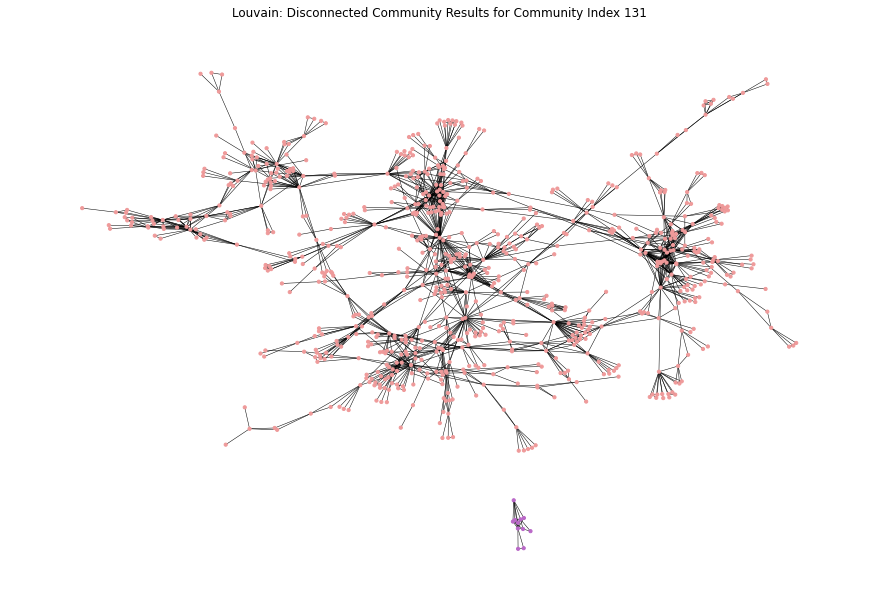

In [63]:
# get subgraph of community with index 131 for demo
disconnected_subgraph = DBLP_network.subgraph(louvain_communities[131])
disconnected_components = list(nx.connected_components(disconnected_subgraph))

# create visualization
node_colors = create_community_node_colors(disconnected_subgraph, disconnected_components)
pos = nx.spring_layout(disconnected_subgraph, iterations=50, k=0.05,
                       seed=2)

plt.figure(1,figsize=(12,8)) 
nx.draw(disconnected_subgraph,
        pos = pos,
        node_size=10,
        width=0.5,
        node_color=node_colors)
plt.title("Louvain Results with Disconnected Community Result for Community Index 131")
plt.show() 

### Louvain algorithm doesn't guarantee communities are connected by itself. Leiden improved Louvain algorithm with guarantte. Let's take a look the runtime, modularity, and connectivity for Leiden algorithm.

### 2. Leiden Algorithm for Community Detection

In [69]:
%%time

# because it's originally implemented in i-graph, we need to convert NetworkX graph to i-graph to
# use the original implementation
temp_graph = ig.Graph.from_networkx(DBLP_network)

Wall time: 3.74 s


In [82]:
%%time

leiden_communities = leidenalg.find_partition(temp_graph,
                                              partition_type=leidenalg.ModularityVertexPartition, 
                                              seed=0)

Wall time: 7.6 s


### The Leiden algoirthm calculation runtime of 7.6s is much faster compared to Louvain (4 min 57s).

In [89]:
lediden_communities_dict = dict(zip(temp_graph.vs["_nx_name"], leiden_communities.membership))
lediden_communities_list = convert_leiden_communities_to_list(lediden_communities_dict)

Number of unique communities: 259


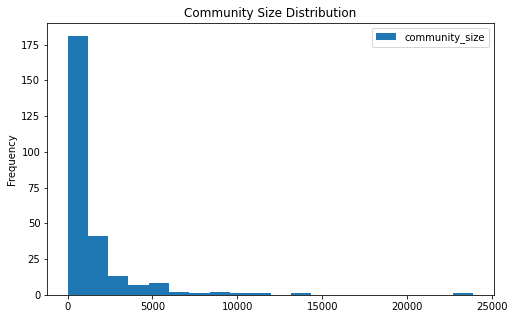

In [93]:
community_sizes = pd.DataFrame([len(community) for community in lediden_communities_list], 
                               columns=["community_size"])
community_sizes.plot.hist(bins=20, figsize=(8,5), title="Community Size Distribution");

In [90]:
%%time

# take a look at the modularity of the Louvain algorithm output
print("Modularity:", 
      round(nx_comm.modularity(DBLP_network, lediden_communities_list), 6))

Modularity: 0.830028
Wall time: 3.83 s


### The modularity score of 0.830028 is higher than Louvain (0.821751).

In [91]:
%%time

check_community_disconnection(DBLP_network, lediden_communities_list)

Total Communities: 259
Total Communities Connected: 259
Disconnected Community Indexes: []
Wall time: 4.66 s


### No disconnected community in Leiden's output. It's better than Louvain with 5 disconnected communities.